In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns
import cupy as cp
from colorama import Fore, Style

In [3]:
clusters = pd.read_csv('data/clustering.csv')
mnist = pd.read_csv('data/MNIST_dataset.csv')

## Base

No hay mucho que ver en los datos, se puede interpretear bastante claramente a simple vista. <br>
Saco la columna redundante de los indices de fila, y g rafico A vs B a ver si me dice algo (en MNIST no hago nada en principio)

In [16]:
# Base Process
clusters = clusters.drop("Unnamed: 0", axis=1)

In [17]:
# Print clusters preview
print(Fore.CYAN + "clusters DataFrame Preview:" + Style.RESET_ALL)
print(clusters.head(n=15))

clusters DataFrame Preview:
         A       B
0   812954  643720
1   868217  609046
2   920248  607272
3   841621  639394
4   843907  598777
5   817712  620917
6   865980  632292
7   876539  639944
8   805247  642901
9   829227  565484
10  834679  669557
11  851242  630615
12  890325  702688
13  832159  638667
14  833736  637738


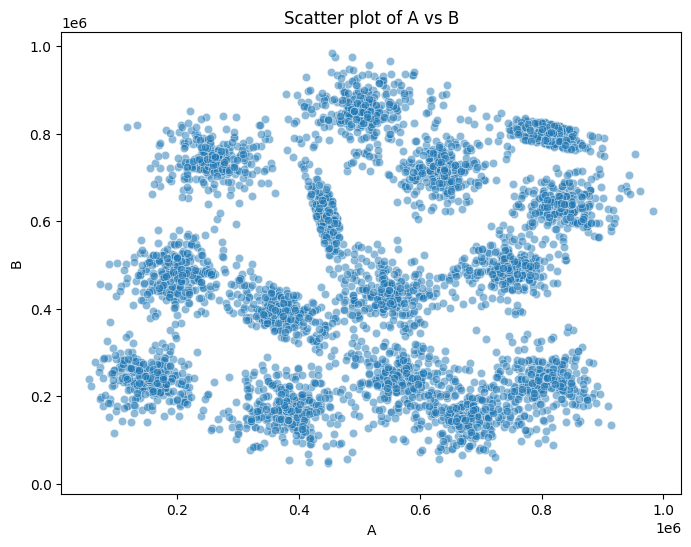

In [18]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=clusters, x='A', y='B', alpha=0.5)
plt.title('Scatter plot of A vs B')
plt.xlabel('A')
plt.ylabel('B')
plt.show()

Se pueden ver varios clusters claros, tambien se puede ver que los valores son muy grandes. Para estabilidad numerica, los puedo dividir a todos por una constante luego de ver sus rangos
<br> Si tuviera que decir alguna adivinanza inicial, supongo que 14-16 clusters podrian verse

In [19]:
# Veo sus rangos
summary = {
    'A_lowest': clusters['A'].nsmallest(5).values,
    'A_highest': clusters['A'].nlargest(5).values,
    'B_lowest': clusters['B'].nsmallest(5).values,
    'B_highest': clusters['B'].nlargest(5).values
}
summary_table = pd.DataFrame(summary)
print(Fore.YELLOW + "5 lowest and 5 highest values for each column in clusters:" + Style.RESET_ALL)
print(summary_table)

5 lowest and 5 highest values for each column in clusters:
   A_lowest  A_highest  B_lowest  B_highest
0     55608     983609     25631     984555
1     58050     961248     30810     975112
2     64731     954037     47368     974808
3     70828     945668     50189     965047
4     72179     944095     53060     956802


Con estos valores, puedo dividir por 10,000 por ejemplo

In [32]:
# Normalization
clust_df = (clusters - clusters.min()) / (clusters.max() - clusters.min())
clust = clust_df.values

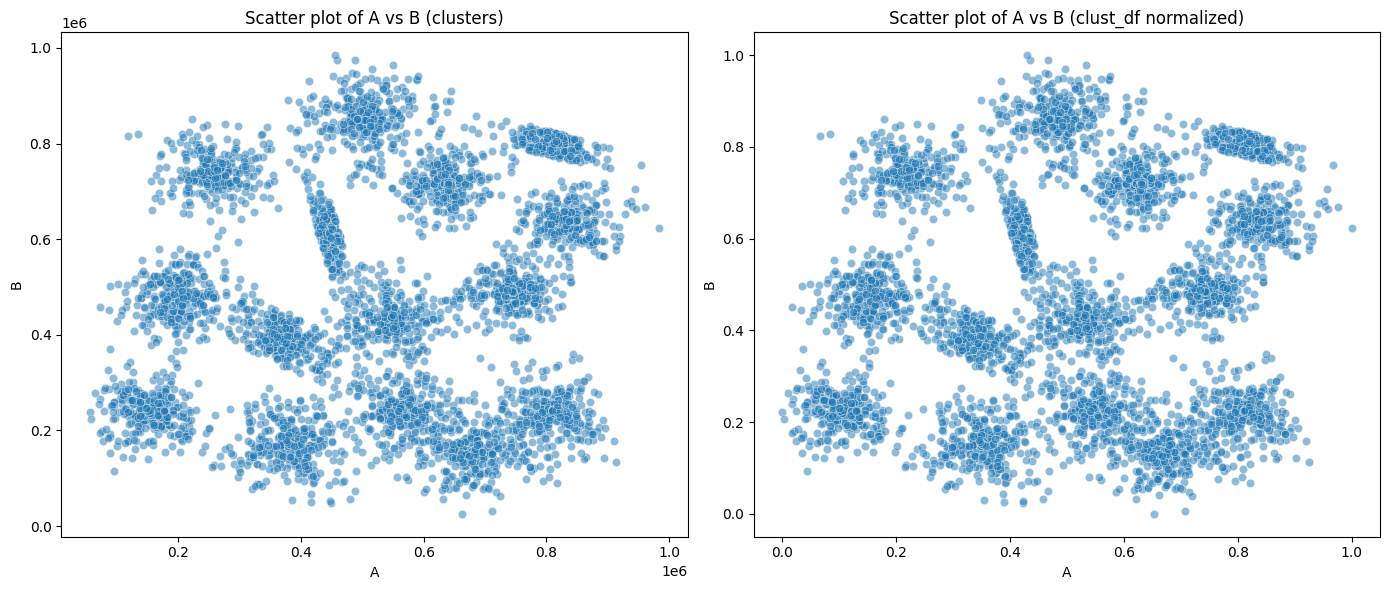

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot clusters (original scale)
sns.scatterplot(data=clusters, x='A', y='B', alpha=0.5, ax=axes[0])
axes[0].set_title('Scatter plot of A vs B (clusters)')
axes[0].set_xlabel('A')
axes[0].set_ylabel('B')

# Plot clust_df (normalized)
sns.scatterplot(data=clust_df, x='A', y='B', alpha=0.5, ax=axes[1])
axes[1].set_title('Scatter plot of A vs B (clust_df normalized)')
axes[1].set_xlabel('A')
axes[1].set_ylabel('B')

plt.tight_layout()
plt.show()

In [34]:
# Pandas Magic para visualizar que todo salio bien
clust_preview = pd.DataFrame(clust[:15], columns=clust_df.columns)
separator = pd.DataFrame([['', '']] * 15, columns=['xd', 'xd'])

clust_preview_rounded = clust_preview.round(4).map(lambda x: f"{x:.4f}")
clust_df_rounded = clust_df.head(15).reset_index(drop=True).round(4).map(lambda x: f"{x:.4f}")

full_table = pd.concat([clust_preview_rounded, separator, clust_df_rounded, separator, clusters.head(15).reset_index(drop=True)], axis=1)
full_table.columns = ['clust_A', 'clust_B', '', '', 'clust_df_A', 'clust_df_B', '', '', 'clusters_A', 'clusters_B']
print(full_table.to_string(index=False))

clust_A clust_B   clust_df_A clust_df_B    clusters_A  clusters_B
 0.8161  0.6446       0.8161     0.6446        812954      643720
 0.8757  0.6084       0.8757     0.6084        868217      609046
 0.9317  0.6066       0.9317     0.6066        920248      607272
 0.8470  0.6401       0.8470     0.6401        841621      639394
 0.8495  0.5977       0.8495     0.5977        843907      598777
 0.8212  0.6208       0.8212     0.6208        817712      620917
 0.8732  0.6326       0.8732     0.6326        865980      632292
 0.8846  0.6406       0.8846     0.6406        876539      639944
 0.8078  0.6437       0.8078     0.6437        805247      642901
 0.8336  0.5630       0.8336     0.5630        829227      565484
 0.8395  0.6715       0.8395     0.6715        834679      669557
 0.8574  0.6309       0.8574     0.6309        851242      630615
 0.8995  0.7061       0.8995     0.7061        890325      702688
 0.8368  0.6393       0.8368     0.6393        832159      638667
 0.8385  0

Con el procesamiento de datos finalizado, empiezo el trabajo

In [35]:
import importlib
import utils
import cupy as cp
importlib.reload(utils)
X_cp = cp.asarray(clust)

# 1)

### K-Means

Testeo que funcione una call

In [36]:
Ks = range(1, 30)
L_dists = []
data = {}
cp.random.seed(42)

for K in Ks:
    labels_cp, centroids_cp = utils.kmeans(X=X_cp, K=K, max_iters=1000, rel_tol=1e-8, abs_tol=1e-8)
    L = utils.compute_L(X_cp, labels_cp, centroids_cp)
    L_dists.append(L)
    data[K] = [labels_cp, centroids_cp, L]

K-Means (K=29):   2%|▏         | 23/1000 [00:00<00:14, 66.84iter/s]


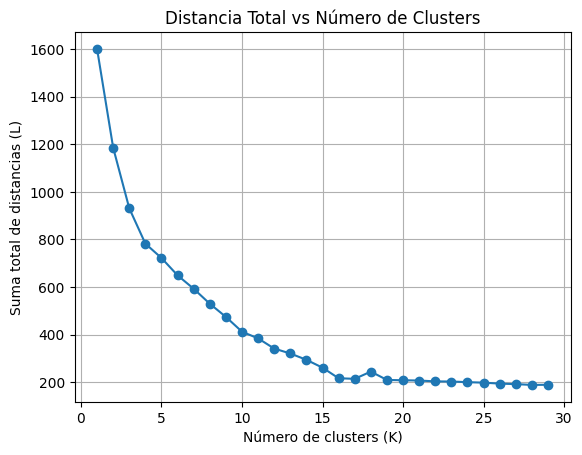

In [37]:
plt.plot(Ks, np.array(L_dists), marker='o')
plt.xlabel("Número de clusters (K)")
plt.ylabel("Suma total de distancias (L)")
plt.title("Distancia Total vs Número de Clusters")
plt.grid(True)
plt.show()

Aca ya puedo ver unas diminishing gains claras (como era de esperar). Quizas irse hasta mas que la 16 podria ser demasiado lejos, pero ya puedo ir poniendo si o si un limite mental ahi.<br>Podria verse que a partir de 4 clusters se empiezan a tener ganancias decrecientes, pero viendo que siguen bajando consistentemente y considerando mis expectativas iniciales al observar la distribucion del dataset, considero que frenar en k=4 seria demasiado temprano, y se perderia demasiada informacion.<br>Algunos puntos para considerar creo que podrian ser k=10, o k=12, o k=16

In [38]:
print(Style.BRIGHT + "K vs L_dist with ΔL and % Drop:" + Style.RESET_ALL)
print(f"{'K':>2} | {'L':>12} | {'ΔL':>12} | {'% Drop':>8}")
print("-" * 42)

for i, (k, l) in enumerate(zip(Ks, L_dists)):
    if i == 0:
        print(f"{k:2d} | {l:12.2f} | {'—':>12} | {'—':>8}")
    else:
        diff = L_dists[i - 1] - l
        percentage = 100 * diff / L_dists[i - 1]
        print(f"{k:2d} | {l:12.2f} | {diff:12.2f} | {percentage:7.2f}%")


K vs L_dist with ΔL and % Drop:
 K |            L |           ΔL |   % Drop
------------------------------------------
 1 |      1599.94 |            — |        —
 2 |      1184.97 |       414.97 |   25.94%
 3 |       930.69 |       254.29 |   21.46%
 4 |       782.28 |       148.40 |   15.95%
 5 |       722.02 |        60.26 |    7.70%
 6 |       649.20 |        72.82 |   10.09%
 7 |       592.88 |        56.32 |    8.67%
 8 |       530.05 |        62.84 |   10.60%
 9 |       474.72 |        55.33 |   10.44%
10 |       412.63 |        62.09 |   13.08%
11 |       384.57 |        28.06 |    6.80%
12 |       341.74 |        42.83 |   11.14%
13 |       321.14 |        20.60 |    6.03%
14 |       294.61 |        26.53 |    8.26%
15 |       261.58 |        33.03 |   11.21%
16 |       217.18 |        44.40 |   16.97%
17 |       214.81 |         2.38 |    1.09%
18 |       245.12 |       -30.32 |  -14.11%
19 |       210.15 |        34.97 |   14.27%
20 |       208.74 |         1.42 |    0.67%
2

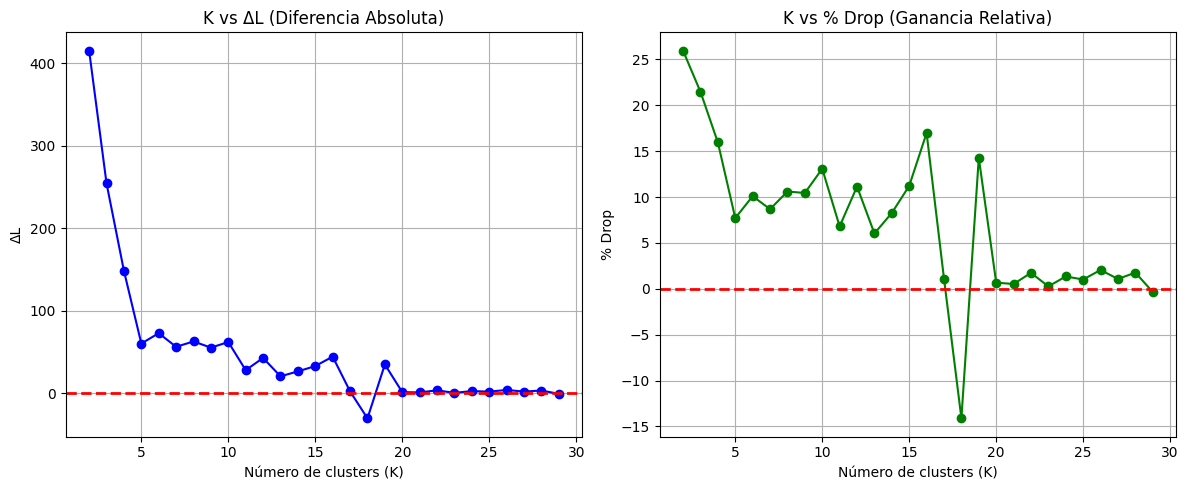

In [39]:
diff_L = [None] + [L_dists[i - 1] - L_dists[i] for i in range(1, len(L_dists))]
pct_drop = [None] + [100 * (L_dists[i - 1] - L_dists[i]) / L_dists[i - 1] for i in range(1, len(L_dists))]

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# K vs ΔL
ax1.plot(Ks[1:], diff_L[1:], marker='o', color='blue')
ax1.axhline(0, color='red', linestyle='--', linewidth=2)
ax1.set_title("K vs ΔL (Diferencia Absoluta)")
ax1.set_xlabel("Número de clusters (K)")
ax1.set_ylabel("ΔL")
ax1.grid(True)

# K vs % Drop
ax2.plot(Ks[1:], pct_drop[1:], marker='o', color='green')
ax2.axhline(0, color='red', linestyle='--', linewidth=2)
ax2.set_title("K vs % Drop (Ganancia Relativa)")
ax2.set_xlabel("Número de clusters (K)")
ax2.set_ylabel("% Drop")
ax2.grid(True)

plt.tight_layout()
plt.show()

**IMPORTANTE PARA LEER ESTOS GRAFICOS QUE LOS PUNTOS EN X=K, REFIEREN A LA DIFERENCIA ENTRE LA TRANSICION X=K-1 -> X=K**

Es importante considerar la caida en % tambien, ya que teniendo diferencias muy altas, siempre va a haber una gran caida de ganancias al principio, aunque esto no cuente la historia entera. Como se puede ver en el grafico del % Drop, si hay una caida de error que a partir de k=4 se vuelve un poco menos pronunciada, pero solo ligeramente, manteniendose con mejoras constantes y significativas, hasta que k=16. 

En base a estos resultados, me inclino mas fuertemente por k=16 como un buen punto para elegir una cantidad de clusters que evite el efecto de mas iteraciones con ganancias decrecientes, pero sin perderse demasiado cortando muy temprano.<br>

Sin embargo, por ultimo para estar seguro, hago el plot de mis 4 opciones (4, 10, 12, 16 clusters) para ver como se ven a ojo, aunque ya para este punto tengo pocas dudas de elegir k=16 como mi cantidad final de clusters

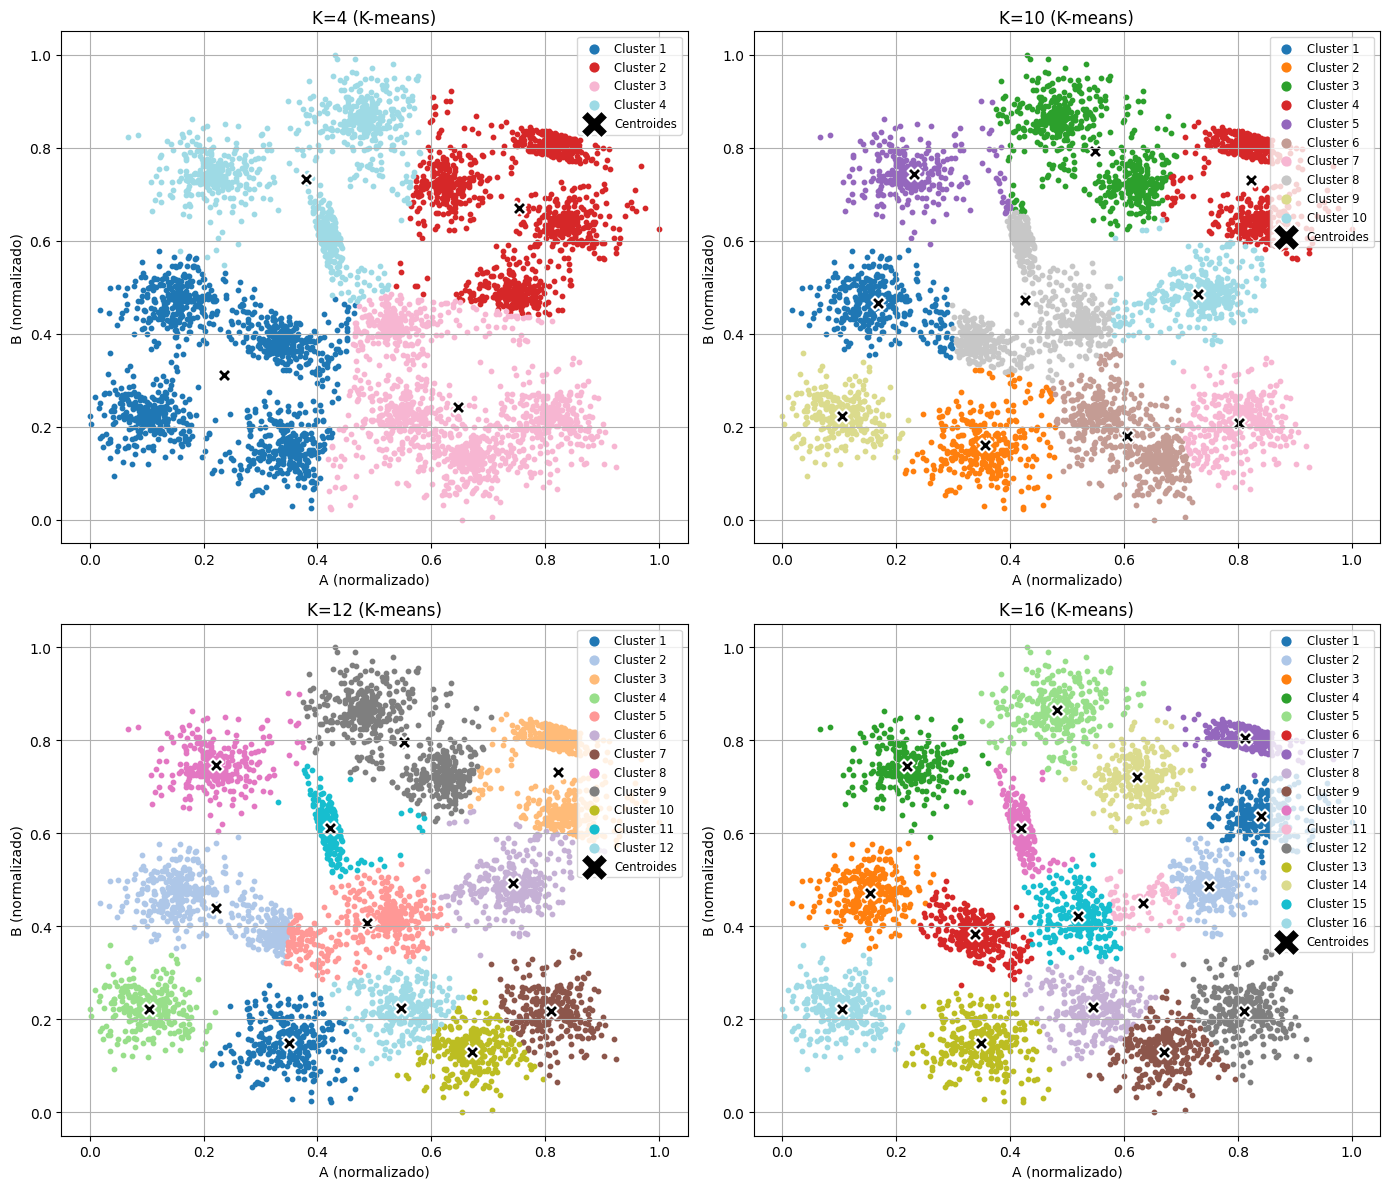

In [40]:
# Get the values
labels4, centroids4, L4 = data[4]
labels10, centroids10, L10 = data[10]
labels12, centroids12, L12 = data[12]
labels16, centroids16, L16 = data[16]

labels4 = cp.asnumpy(labels4)
centroids4 = cp.asnumpy(centroids4)
labels10 = cp.asnumpy(labels10)
centroids10 = cp.asnumpy(centroids10)
labels12 = cp.asnumpy(labels12)
centroids12 = cp.asnumpy(centroids12)
labels16 = cp.asnumpy(labels16)
centroids16 = cp.asnumpy(centroids16)

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

configs = [
    (labels4, centroids4, 4, axes[0, 0]),
    (labels10, centroids10, 10, axes[0, 1]),
    (labels12, centroids12, 12, axes[1, 0]),
    (labels16, centroids16, 16, axes[1, 1]),
]

for labels, centroids, k_val, ax in configs:
    num_clusters = len(np.unique(labels))
    colors = plt.cm.tab20(np.linspace(0, 1, num_clusters))

    for k in range(num_clusters):
        cluster_points = clust[labels == k]
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1],
                    s=10, color=colors[k], label=f"Cluster {k+1}")

    ax.scatter(centroids[:, 0], centroids[:, 1],
                s=100, c='black', marker='X', edgecolors='white', linewidths=1.5, label='Centroides')
    ax.set_xlabel("A (normalizado)")
    ax.set_ylabel("B (normalizado)")
    ax.set_title(f"K={k_val} (K-means)")
    ax.grid(True)
    ax.legend(markerscale=2, fontsize='small', loc='upper right')

plt.tight_layout()
plt.show()

Confirmado, me quedo con k=16, pero ni una mas. K=12 tambien se ve ya muy bien distribuida, menos que eso generaliza demasiado (k=10 algunos que se sienten muy estirados, k=4 es una buena generalizacion para simpleza, pero da demasiada poca informacion para mi gusto)

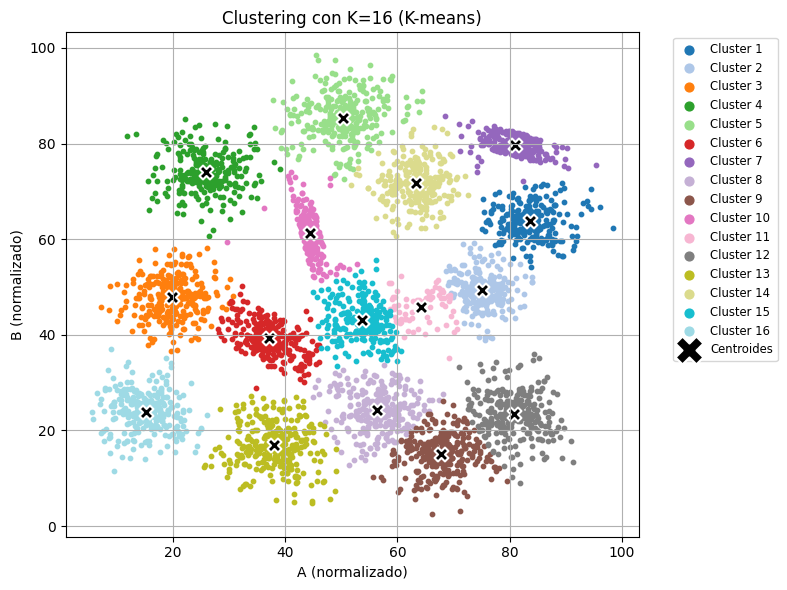

In [33]:
# Get the values from k=16
labels16, centroids16, L16 = data[16]
labels = cp.asnumpy(labels16)
centroids = cp.asnumpy(centroids16)

# Plot colores
plt.figure(figsize=(8, 6))
num_clusters = len(np.unique(labels))
colors = plt.cm.tab20(np.linspace(0, 1, num_clusters))

for k in range(num_clusters):
    cluster_points = clust[labels == k]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                s=10, color=colors[k], label=f"Cluster {k+1}")

# Plot centroids
plt.scatter(centroids[:, 0], centroids[:, 1],
            s=100, c='black', marker='X', edgecolors='white', linewidths=1.5, label='Centroides')

plt.xlabel("A (normalizado)")
plt.ylabel("B (normalizado)")
plt.title("Clustering con K=16 (K-means)")
plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

### Mezcla de Gaussianas

In [10]:
importlib.reload(utils)

<module 'utils' from 'c:\\Users\\manue\\Desktop\\manum\\coding\\ML-TP4\\utils.py'>

En vez de solo probar con k=16, hago otro barrido de Ks como hice antes

In [11]:
Ks = range(1, 30)
L_values = []
gmm_data = {}
cp.random.seed(42)
rel_tol = 1e-5
abs_tol = 1e-5

for ka in Ks:
    _, centroids_k, _ = data[ka]
    means, covs, weights = utils.initialize_gmm(X_cp, K=ka, centroids=centroids_k)
    means, covs, weights = cp.asarray(means), cp.asarray(covs), cp.asarray(weights)

    gamma, means, covs, weights = utils.run_gaussian_mixture(
        X=X_cp, k=ka, means=means, covs=covs, weights=weights,
        max_iters=2500, rtol=rel_tol, atol=abs_tol)

    cluster_labels = cp.argmax(gamma, axis=1) # a cada dato, la label (posicion) que tenga mayor gamma ("gamma" mi variable tiene los datos y sus actual gammas)
    L_gmm = utils.compute_GM_Loss(X_cp, means, covs, weights)
    L_values.append(L_gmm)

    gmm_data[ka] = {
        'means': cp.asnumpy(means),
        'covs': cp.asnumpy(covs),
        'weights': cp.asnumpy(weights),
        'labels': cp.asnumpy(cluster_labels),
        'loss': L_gmm
    }

GMM K=29:  35%|███▌      | 877/2500 [00:51<01:36, 16.88iter/s]


In [16]:
# Remake L_values turning each element into a float version of itself 
L_values = [float(x) for x in L_values]

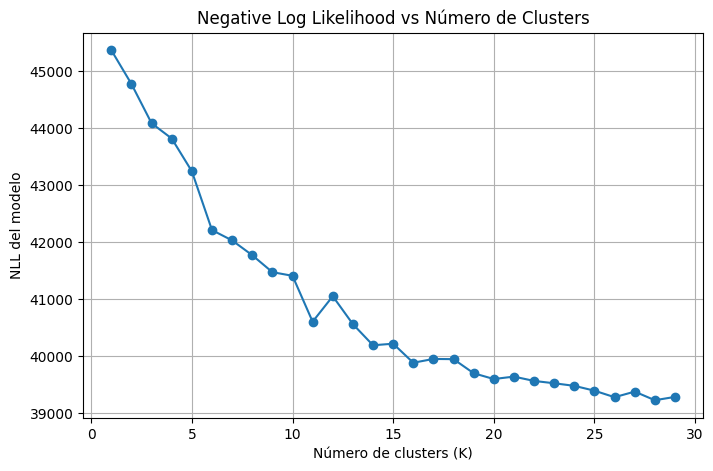

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(Ks, np.array(L_values), marker='o')
plt.xlabel("Número de clusters (K)")
plt.ylabel("NLL del modelo")
plt.title("Negative Log Likelihood vs Número de Clusters")
plt.grid(True)
plt.show()

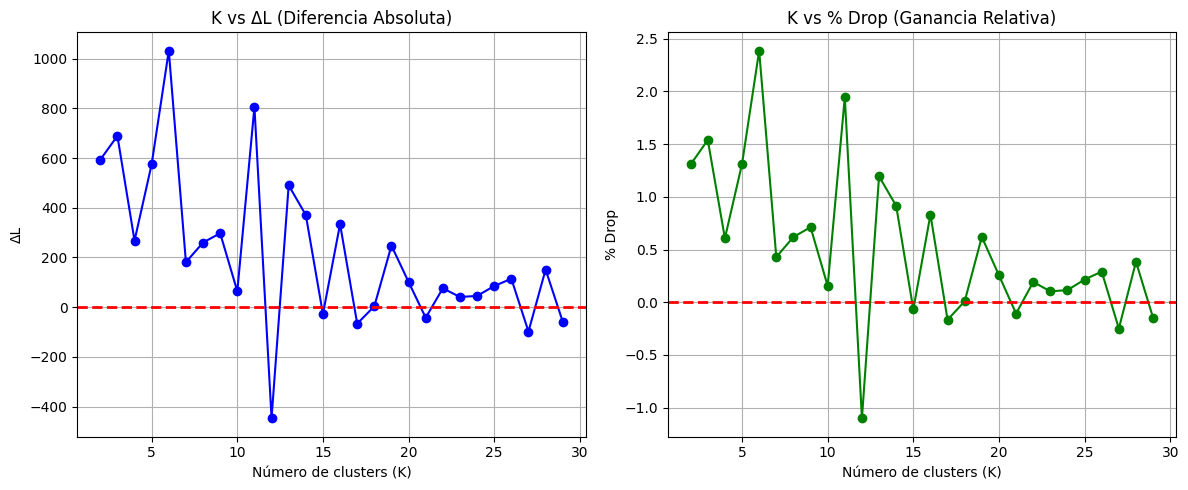

In [20]:
diff_L = [None] + [L_values[i - 1] - L_values[i] for i in range(1, len(L_values))]
pct_drop = [None] + [100 * (L_values[i - 1] - L_values[i]) / L_values[i - 1] for i in range(1, len(L_values))]

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# K vs ΔL
ax1.plot(Ks[1:], diff_L[1:], marker='o', color='blue')
ax1.axhline(0, color='red', linestyle='--', linewidth=2)
ax1.set_title("K vs ΔL (Diferencia Absoluta)")
ax1.set_xlabel("Número de clusters (K)")
ax1.set_ylabel("ΔL")
ax1.grid(True)

# K vs % Drop
ax2.plot(Ks[1:], pct_drop[1:], marker='o', color='green')
ax2.axhline(0, color='red', linestyle='--', linewidth=2)
ax2.set_title("K vs % Drop (Ganancia Relativa)")
ax2.set_xlabel("Número de clusters (K)")
ax2.set_ylabel("% Drop")
ax2.grid(True)

plt.tight_layout()
plt.show()

Veo las que me parecen relevantes

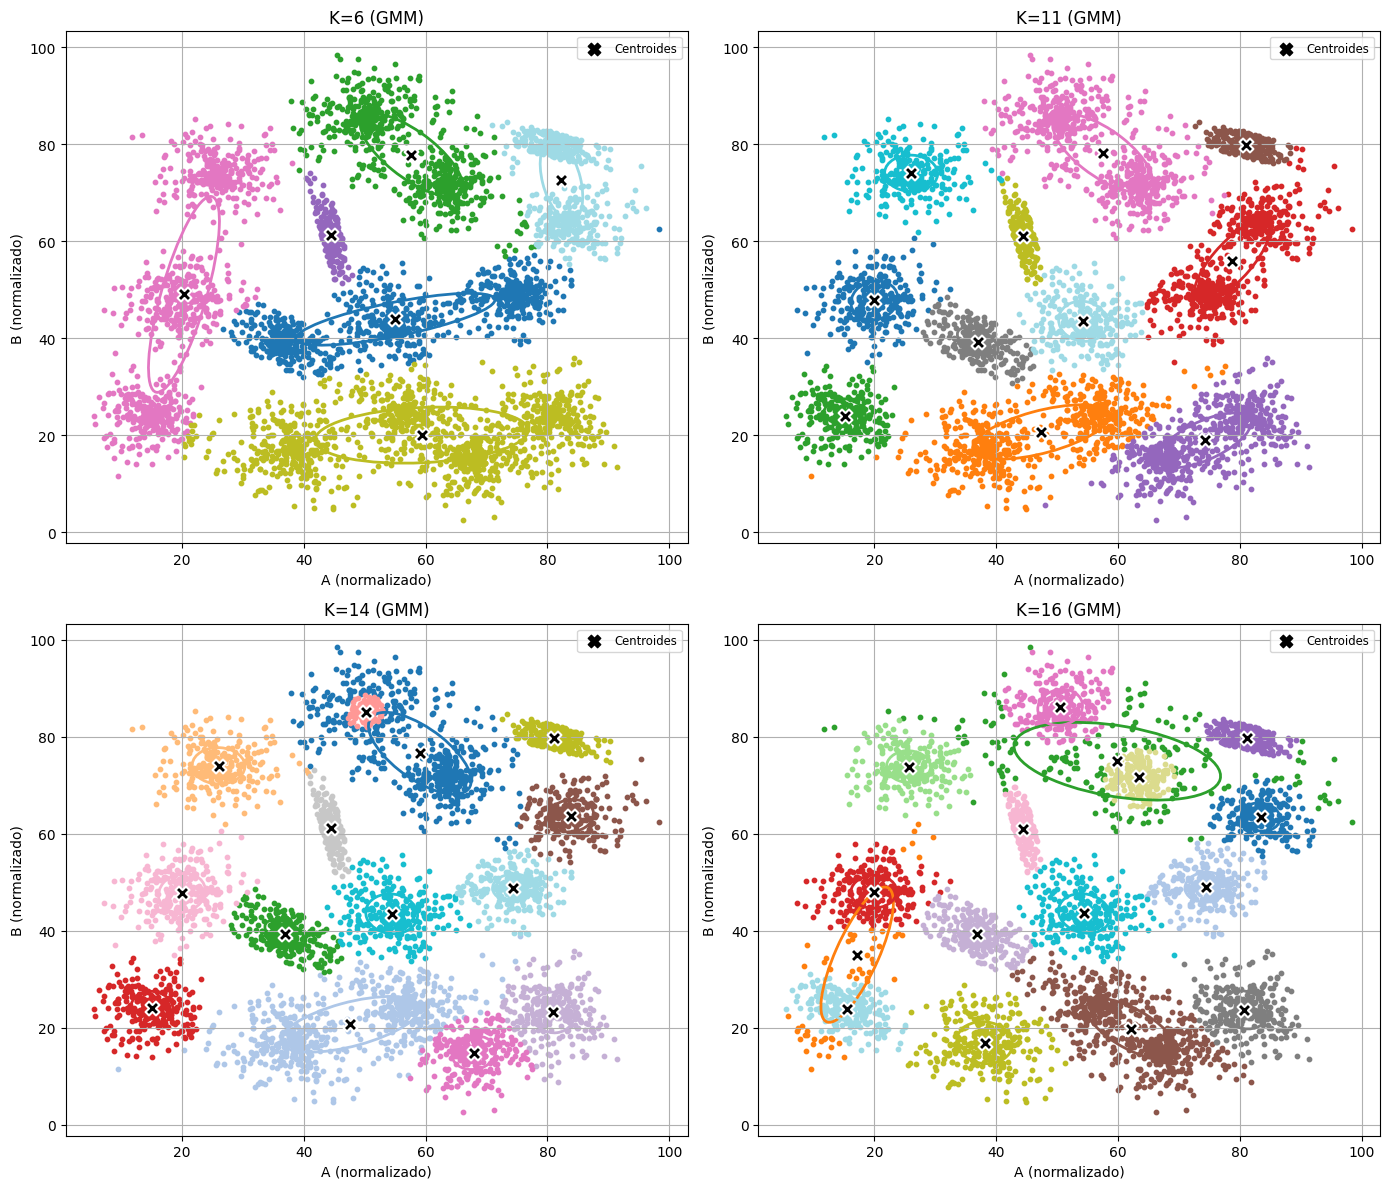

In [36]:
clust_np = cp.asnumpy(X_cp)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
Ks_to_plot = [6, 11, 14, 16]

for ax, k_val in zip(axes.flatten(), Ks_to_plot):
    gmm = gmm_data[k_val]
    labels = gmm['labels']
    means = gmm['means']
    covs = gmm['covs']
    
    num_clusters = len(np.unique(labels))
    colors = plt.cm.tab20(np.linspace(0, 1, num_clusters))

    for k in range(num_clusters):
        cluster_points = clust_np[labels == k]
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1],
                    s=10, color=colors[k], zorder=1)

        # Mean (centroid)
        ax.scatter(means[k, 0], means[k, 1],
                    s=100, c='black', marker='X', edgecolors='white', linewidths=1.5, zorder=4)

        # Ellipse for 1-sigma contour
        utils.draw_ellipse(means[k], covs[k], ax, color=colors[k])

    ax.scatter([], [], c='black', marker='X', s=20, label='Centroides')
    ax.set_title(f"K={k_val} (GMM)")
    ax.set_xlabel("A (normalizado)")
    ax.set_ylabel("B (normalizado)")
    ax.grid(True)
    ax.legend(markerscale=2, fontsize='small', loc='upper right')

plt.tight_layout()
plt.show()

Elijo K=11, considerando como las elipses de menor varianza tienen error exponencialmente menor cuando contienen la mayoria de sus datos cerca de su centroide, y este error crece exponencialmente con respecto a la varianza a medida que los datos se alejan de dicho centro, o $μ_k$.

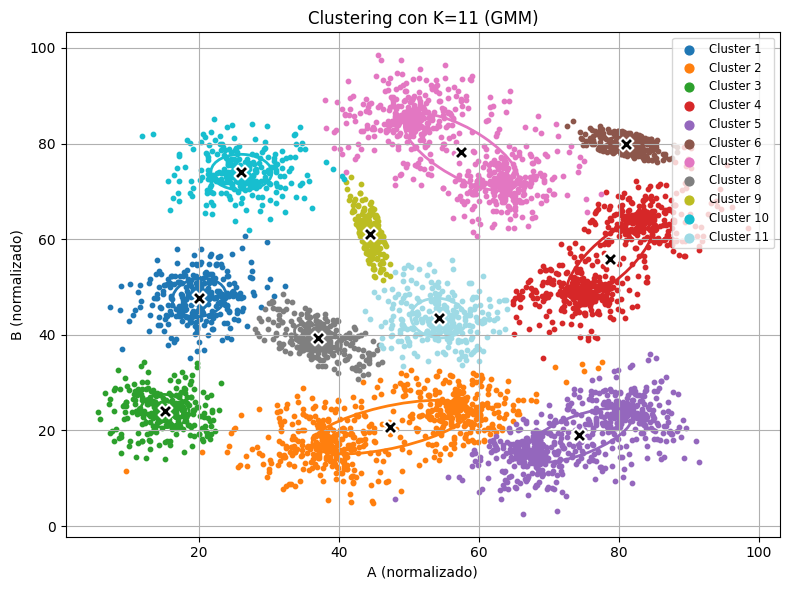

In [38]:
# Extract points (same as your 'clust' from earlier)
clust_np = cp.asnumpy(X_cp)
final_k = 11
gmm = gmm_data[final_k]
labels = gmm['labels']
means = gmm['means']
covs = gmm['covs']

fig, ax = plt.subplots(figsize=(8, 6))
num_clusters = len(np.unique(labels))
colors = plt.cm.tab20(np.linspace(0, 1, num_clusters))

for k in range(num_clusters):
    cluster_points = clust_np[labels == k]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1],
                s=10, color=colors[k], label=f"Cluster {k+1}", zorder=1)

    ax.scatter(means[k, 0], means[k, 1],
                s=100, c='black', marker='X', edgecolors='white', linewidths=1.5, zorder=4)

    utils.draw_ellipse(means[k], covs[k], ax, color=colors[k]) 

ax.set_title(f"Clustering con K={final_k} (GMM)")
ax.set_xlabel("A (normalizado)")
ax.set_ylabel("B (normalizado)")
ax.grid(True)
ax.legend(markerscale=2, fontsize='small', loc='upper right')

plt.tight_layout()
plt.show()


En base a todos estos resultados, puedo determinar que modelando con una Mezcla de Gaussianas, el mejor valor de K (cantidad de clusters) para traer valiosa informacion y buenas clasificaciones, sin sobreoptimizar hasta el punto de la redundancia, es K=14.

### 1c) DBSCAN

In [100]:
importlib.reload(utils)

<module 'utils' from 'c:\\Users\\manue\\Desktop\\manum\\coding\\ML-TP4\\utils.py'>

In [101]:
dist_matrix = utils.get_distance_matrix(X_cp)
dists_np = cp.asnumpy(dist_matrix)

np.fill_diagonal(dists_np, np.inf)
min_dists = dists_np.min(axis=1)
print(f"Median min distance: {np.median(min_dists):.2f}")
print(f"Max min distance: {np.max(min_dists):.2f}")
print(f"Average min distance: {np.mean(min_dists):.2f}")

markers = ['o', 's', '^', 'v', 'P', '*', 'X', 'D', '<', '>', 'H']
clust_np = cp.asnumpy(X_cp)

Median min distance: 0.31
Max min distance: 5.05
Average min distance: 0.44


Barrido de Ks chicos

In [ ]:
eps_values = [1, 1.5, 2, 2.5, 3]
min_pts_values = [2, 3, 4, 6, 8]

utils.run_dbscan_plots(dist_matrix, clust_np, eps_values, min_pts_values, markers)

Barrido de Ks grandes

In [ ]:
eps_values = [3.5, 4, 4.5, 5, 6]
min_pts_values = [10, 20, 25, 45, 70, 100]

utils.run_dbscan_plots(dist_matrix, clust_np, eps_values, min_pts_values, markers)

Casos Borde K

In [ ]:
eps_values = [1, 2, 3, 6, 9]
min_pts_values = [0, 1, 100, 200, 500]

utils.run_dbscan_plots(dist_matrix, clust_np, eps_values, min_pts_values, markers)

Casos Borde Epsilon

In [ ]:
eps_values = [0.001, 100]
min_pts_values = [0, 5, 10, 100]

utils.run_dbscan_plots(dist_matrix, clust_np, eps_values, min_pts_values, markers)

Narrow down a los mejores casos

In [ ]:
eps_values = [0.001, 100]
min_pts_values = [0, 5, 10, 100]

utils.run_dbscan_plots(dist_matrix, clust_np, eps_values, min_pts_values, markers)

# 2) Reduccion de Dimensionalidad

In [93]:
importlib.reload(utils)
from tqdm import tqdm

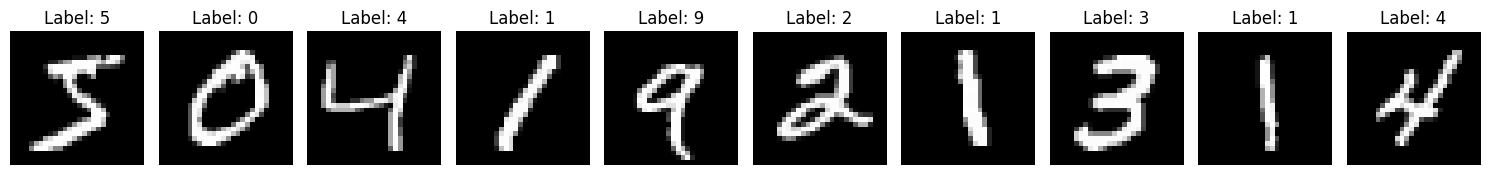

In [4]:
# Preview (aunque ya todos conocemos mnist)
num_samples = 10
fig, axes = plt.subplots(1, num_samples, figsize=(15, 2))

for i in range(num_samples):
    img = mnist.iloc[i, 1:].values.reshape(28, 28)
    label = mnist.iloc[i, 0]
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [11]:
from IPython.display import display

# Cargo y Normalizo
mnist_nolabel = mnist.drop(columns=['label'])
mnist_nolabel = mnist_nolabel.astype(np.float32) / 255.0

# Preview mnist and mnist_nolabel as horizontal tables
print(Fore.CYAN + "mnist DataFrame Preview:" + Style.RESET_ALL)
display(mnist.head(5).style.set_properties(**{'max-width': '200px'}))
print(Fore.CYAN + "mnist_nolabel DataFrame Preview:" + Style.RESET_ALL)
display(mnist_nolabel.head(5).style.set_properties(**{'max-width': '200px'}))

Xm = cp.array(mnist_nolabel.values)

mnist DataFrame Preview:


mnist_nolabel DataFrame Preview:


In [ ]:
component_range = list(range(1, 785, 1))
errors = []
variances = []

for k in tqdm(component_range, desc="Computing PCA reconstruction errors"):
    X_transformed, components, X_mean, retained_ratio = utils.pca(Xm, k)
    X_reconstructed = utils.pca_reconstruct(X_transformed, components, X_mean)
    mse = utils.reconstruction_mse(Xm, X_reconstructed)
    errors.append(cp.asnumpy(mse))

In [ ]:
# Plot Errors
plt.figure(figsize=(8, 5))
plt.plot(component_range, errors, marker='o', markersize=4)
plt.xlabel("Numero de Componentes")
plt.ylabel("MSE de Reconstrucción")
plt.title("Error para cada número de componentes")
plt.grid(True)
plt.show()

Plotteo en menos espacio de X, para ver mas claramente como se ven menos dimensiones

In [ ]:
# Plot errors from element 19 to 300
plt.figure(figsize=(8, 5))
plt.plot(component_range[18:300], errors[18:300], marker='o')
plt.xlabel("Numero de Componentes")
plt.ylabel("MSE de Reconstrucción")
plt.title("Error para cada número de componentes (19 a 300)")
plt.grid(True)
plt.show()

### 2b)

Tengo que buscar un punto medio que combina la mayor eficiencia de computo con la preservacion de la mayoria de la informacion relevante, para luego hacer la reconstrucción.
Voy a graficar el % de varianza preservado a medida que se reducen los componentes, trazando unas lineas en marcas notables como 50%, 70%, 80%, 90%, 95%, 99%

In [ ]:
# Plot Errors
plt.figure(figsize=(8, 5))
plt.plot(component_range, variances, marker='o', markersize=4)
plt.xlabel("Numero de Componentes")
plt.ylabel("MSE de Reconstrucción")
plt.title("Error para cada número de componentes")
plt.grid(True)
plt.show()

, con esto en cuenta voy a ver un ejemplo visual de como se ven las 4 cantidades que sigo teniendo en consideracion, como test final para determinar cual elijo

In [ ]:
components_list = [25, 85, 100, 200]
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for ax, num_components in zip(axes.flat, components_list):
    # Apply PCA and reconstruct
    X_transformed, components, X_mean = utils.pca(Xm, num_components)
    X_reconstructed = utils.pca_reconstruct(X_transformed, components, X_mean)

    original = cp.asnumpy(Xm[0]).reshape(28, 28)
    reconstructed = cp.asnumpy(X_reconstructed[0]).reshape(28, 28)

    # Concatenate side-by-side
    comparison = np.hstack([original, reconstructed])

    ax.imshow(comparison, cmap='gray')
    ax.set_title(f"{num_components} Components")
    ax.axis('off')

plt.tight_layout()
plt.show()


En base a esto, me quedo como eleccion final a 85, como ya mencionado, debido a su gran combinacion de eficiencia con efectividad, eliminando la gran mayoria del ruido, y preservando la mayoria de la informacion relevante al mismo tiempo

In [ ]:
CHOSEN_DIMENSIONS = d

In [ ]:
num_components = CHOSEN_DIMENSIONS

# Hago PCA
X_transformed, components, X_mean = utils.pca(Xm, num_components)
X_reconstructed = utils.pca_reconstruct(X_transformed, components, X_mean)

original_imgs = cp.asnumpy(Xm[:10])
reconstructed_imgs = cp.asnumpy(X_reconstructed[:10])

# Plot
fig, axes = plt.subplots(10, 2, figsize=(4, 20))

for i in range(10):
    # Original
    axes[i, 0].imshow(original_imgs[i].reshape(28, 28), cmap='gray')
    axes[i, 0].set_title(f'Original {i}')
    axes[i, 0].axis('off')

    # Reconstructed
    axes[i, 1].imshow(reconstructed_imgs[i].reshape(28, 28), cmap='gray')
    axes[i, 1].set_title(f'Reconstructed {i}')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

### c) Variational AutoEncoder

In [42]:
import torch
from torch.utils.data import DataLoader, random_split, TensorDataset

# Use the same X as before (labels excluded)
X_tensor = torch.tensor(cp.asnumpy(Xm), dtype=torch.float32) / 255.0  # normalize to [0, 1]
dataset = TensorDataset(X_tensor)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128)

In [ ]:
# Load como loaders/tensors de PyTorch
X = cp.asnumpy(Xm)
X_tensor = torch.tensor(X, dtype=torch.float32)
dataset = TensorDataset(X_tensor)

# Train-Val Split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128)

In [ ]:
# if torch.cuda.is_available():
#     print(torch.cuda.get_device_name(torch.cuda.current_device()))
# else:
#     print("CUDA is not available.")

In [ ]:
# Entreno con GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = utils.VA_Encoder(input_dim=784, hidden_dim=400, latent_dim=20)
utils.train_vae(model, train_loader, val_loader, epochs=30, lr=1e-3, device=device)

In [ ]:
# desabilita ciertas cosas de training como el dropout o el batchnorm para que los resultados del predict sean consitentes
model.eval()

# Sample 10 random validation examples
with torch.no_grad():
    indices = random.sample(range(len(val_set)), 10)
    samples = torch.stack([val_set[i][0] for i in indices]).to(device)
    reconstructions, _, _ = model(samples)

# Prepare plot: one row per sample (original + reconstructed)
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(8, 20))
fig.suptitle("VAE Reconstructions vs. Originals", fontsize=16, y=1.02)

for i in range(10):
    # Original
    axes[i, 0].imshow(samples[i].cpu().view(28, 28), cmap='gray')
    axes[i, 0].set_title(f"Original #{i+1}")
    axes[i, 0].axis('off')

    # Reconstructed
    axes[i, 1].imshow(reconstructions[i].cpu().view(28, 28), cmap='gray')
    axes[i, 1].set_title(f"Reconstructed #{i+1}")
    axes[i, 1].axis('off')

# Column titles
axes[0, 0].set_title("Original", fontsize=14)
axes[0, 1].set_title("Reconstructed", fontsize=14)

plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.4)
plt.show()
